Week 1

In [1]:
# =============================
# Standard Libraries
# =============================
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations
from joblib import parallel_backend
from tqdm.auto import tqdm
import kagglehub
from IPython.display import display


# =============================
# Data Science Libraries
# =============================
import numpy as np
import pandas as pd
import optuna

# =============================
# Visualization
# =============================
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import seaborn as sns

# =============================
# Scikit-learn
# =============================
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold,
    ParameterGrid,
)
import sklearn.model_selection._search as sk_search
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeClassifier, LogisticRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
import sklearn.model_selection._validation as sk_validation

# =============================
# Global
# =============================
random_state = 42
N_ROWS = 5_000_000  # sample size for all datasets
pd.set_option("display.float_format", lambda x: f"{x:.6f}")

# =============================
# Utils
# =============================
def dollar_format(x, pos=None):
    return f"${x:,.0f}"

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

def try_read_csv(folder, fname, **kwargs):
    fp = os.path.join(folder, fname)
    return pd.read_csv(fp, **kwargs) if os.path.exists(fp) else None

def list_csvs(folder):
    return [f for f in os.listdir(folder) if f.lower().endswith(".csv")]

def simple_random_sample(df, n_rows=None, frac=None, random_state=42):
    if df is None:
        raise ValueError("df is None")
    n = len(df)
    if (n_rows is None) == (frac is None):
        raise ValueError("pass exactly one of n_rows or frac")
    if frac is not None:
        if not (0 < frac <= 1):
            raise ValueError("frac must be in (0, 1]")
        k = int(np.floor(frac * n))
    else:
        if int(n_rows) <= 0:
            raise ValueError("n_rows must be > 0")
        k = min(int(n_rows), n)
    if k >= n:
        return df.copy()
    t0 = time.perf_counter()
    rng = np.random.default_rng(random_state)
    idx = rng.choice(n, size=k, replace=False)
    out = df.iloc[idx].copy()
    t1 = time.perf_counter()
    print({"rows": n, "picked": int(len(out)), "frac": float(len(out) / n), "elapsed_sec": round(t1 - t0, 3)})
    return out

def stratified_sample(df, y, n_rows=None, frac=None, random_state=42):
    if df is None:
        raise ValueError("df is None")
    y_arr = df[y].to_numpy() if isinstance(y, str) else np.asarray(y)
    n = len(df)
    if len(y_arr) != n:
        raise ValueError("X and y length mismatch")
    if n_rows is not None and frac is not None:
        frac = None
    if n_rows is None and frac is None:
        raise ValueError("provide n_rows or frac")
    if frac is not None:
        if not (0 < frac <= 1):
            raise ValueError("frac must be in (0, 1]")
        test_size = float(frac)
        use_frac, use_n = frac, None
    else:
        if int(n_rows) <= 0:
            raise ValueError("n_rows must be > 0")
        test_size = min(float(n_rows) / n, 1.0)
        use_frac, use_n = None, int(n_rows)
    if test_size >= 1.0:
        return df.copy()
    _, counts = np.unique(y_arr, return_counts=True)
    if np.any(counts < 2):
        print("Warning: some classes <2 samples; using simple sampling.")
        return simple_random_sample(df, n_rows=use_n, frac=use_frac, random_state=random_state)
    t0 = time.perf_counter()
    idx = np.arange(n)
    _, test_idx, _, _ = train_test_split(
        idx, y_arr, test_size=test_size, stratify=y_arr, random_state=random_state
    )
    out = df.iloc[test_idx].copy()
    t1 = time.perf_counter()
    print(
        {
            "rows": n,
            "picked": int(len(out)),
            "frac": float(len(out) / n),
            "elapsed_sec": round(t1 - t0, 3),
            "mode": "stratified",
        }
    )
    return out

# =============================
# Load Steam (sample first)
# =============================
steam_path = kagglehub.dataset_download("antonkozyriev/game-recommendations-on-steam")
print("Steam path:", steam_path, "\n", os.listdir(steam_path))

games = try_read_csv(steam_path, "games.csv", low_memory=False)
users = try_read_csv(steam_path, "users.csv", low_memory=False)
recommendations = try_read_csv(steam_path, "recommendations.csv", low_memory=False)

metadata = None
meta_fp = os.path.join(steam_path, "games_metadata.json")
if os.path.exists(meta_fp):
    metadata = pd.read_json(meta_fp, lines=True)

print(
    "Steam shapes:",
    {
        "games": None if games is None else games.shape,
        "users": None if users is None else users.shape,
        "recommendations": None if recommendations is None else recommendations.shape,
        "metadata": None if metadata is None else metadata.shape,
    },
)

steam = None
if recommendations is not None:
    # sample recommendations
    if "is_recommended" in recommendations.columns:
        recs_sample = stratified_sample(recommendations, y="is_recommended", n_rows=N_ROWS, random_state=random_state)
    else:
        recs_sample = simple_random_sample(recommendations, n_rows=N_ROWS, random_state=random_state)

    gm = games
    if metadata is not None and "app_id" in metadata.columns and games is not None and "app_id" in games.columns:
        gm = games.merge(metadata, on="app_id", how="left")

    steam = recs_sample
    if gm is not None and "app_id" in recs_sample.columns and "app_id" in gm.columns:
        steam = steam.merge(gm, on="app_id", how="left")
    if users is not None and "user_id" in steam.columns and "user_id" in users.columns:
        steam = steam.merge(users, on="user_id", how="left")

    print("steam:", steam.shape)

# =============================
# Load Olist
# =============================
olist_path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")
print("\nOlist path:", olist_path, "\n", os.listdir(olist_path))

olist_customers = try_read_csv(olist_path, "olist_customers_dataset.csv")
olist_geolocation = try_read_csv(olist_path, "olist_geolocation_dataset.csv")
olist_items = try_read_csv(olist_path, "olist_order_items_dataset.csv")
olist_payments = try_read_csv(olist_path, "olist_order_payments_dataset.csv")
olist_reviews = try_read_csv(olist_path, "olist_order_reviews_dataset.csv")
olist_orders = try_read_csv(olist_path, "olist_orders_dataset.csv")
olist_products = try_read_csv(olist_path, "olist_products_dataset.csv")
olist_sellers = try_read_csv(olist_path, "olist_sellers_dataset.csv")
olist_cat_trans = try_read_csv(olist_path, "product_category_name_translation.csv")

print(
    "Olist shapes:",
    {
        "customers": None if olist_customers is None else olist_customers.shape,
        "geolocation": None if olist_geolocation is None else olist_geolocation.shape,
        "items": None if olist_items is None else olist_items.shape,
        "payments": None if olist_payments is None else olist_payments.shape,
        "reviews": None if olist_reviews is None else olist_reviews.shape,
        "orders": None if olist_orders is None else olist_orders.shape,
        "products": None if olist_products is None else olist_products.shape,
        "sellers": None if olist_sellers is None else olist_sellers.shape,
        "category_translation": None if olist_cat_trans is None else olist_cat_trans.shape,
    },
)

olist = None
if all(x is not None for x in [olist_orders, olist_customers, olist_items, olist_products, olist_sellers]):
    # translated category names
    if olist_cat_trans is not None and "product_category_name" in olist_products.columns:
        products_en = olist_products.merge(olist_cat_trans, on="product_category_name", how="left")
    else:
        products_en = olist_products

    # enrich items with product and seller info
    items_ext = (
        olist_items.merge(products_en, on="product_id", how="left")
        .merge(olist_sellers, on="seller_id", how="left", suffixes=("", "_seller"))
    )

    # average lat,lng per ZIP prefix
    if olist_geolocation is not None:
        geo_zip = (
            olist_geolocation.groupby("geolocation_zip_code_prefix", as_index=False).agg(
                geolocation_lat=("geolocation_lat", "mean"),
                geolocation_lng=("geolocation_lng", "mean"),
                geo_points=("geolocation_city", "count"),
            )
        )
        customers_geo = (
            olist_customers.merge(
                geo_zip,
                left_on="customer_zip_code_prefix",
                right_on="geolocation_zip_code_prefix",
                how="left",
            )
            .drop(columns=["geolocation_zip_code_prefix"])
        )
    else:
        customers_geo = olist_customers

    payments_agg = (
        olist_payments.groupby("order_id", as_index=False).agg(
            payment_value_total=("payment_value", "sum"),
            payment_installments_max=("payment_installments", "max"),
            payment_count=("payment_type", "count"),
        )
        if olist_payments is not None
        else None
    )

    reviews_agg = (
        olist_reviews.groupby("order_id", as_index=False).agg(
            review_score_mean=("review_score", "mean"),
            review_count=("review_id", "count"),
        )
        if olist_reviews is not None
        else None
    )

    olist = (
        olist_orders.merge(customers_geo, on="customer_id", how="left")
        .merge(items_ext, on="order_id", how="left")
    )
    if payments_agg is not None:
        olist = olist.merge(payments_agg, on="order_id", how="left")
    if reviews_agg is not None:
        olist = olist.merge(reviews_agg, on="order_id", how="left")

    print("olist:", olist.shape)

    # sample Olist
    olist = simple_random_sample(olist, n_rows=N_ROWS, random_state=random_state)
    print("olist sample:", olist.shape)

# Run immediately after loading/creating `olist`
base_cols = [
    "order_id","customer_id","order_status","order_purchase_timestamp",
    "order_approved_at","order_delivered_carrier_date",
    "order_delivered_customer_date","order_estimated_delivery_date",
    "customer_unique_id","customer_zip_code_prefix","customer_city",
    "customer_state","geolocation_lat","geolocation_lng","geo_points",
    "order_item_id","product_id","seller_id","shipping_limit_date","price",
    "freight_value","product_category_name","product_name_lenght",
    "product_description_lenght","product_photos_qty","product_weight_g",
    "product_length_cm","product_height_cm","product_width_cm",
    "product_category_name_english","seller_zip_code_prefix","seller_city",
    "seller_state","payment_value_total","payment_installments_max",
    "payment_count","review_score_mean","review_count"
]

idx_map = {}
cols_set = set(olist.columns)
for i, name in enumerate(base_cols):
    if i in cols_set:
        idx_map[i] = name
    if str(i) in cols_set:
        idx_map[str(i)] = name

olist = olist.rename(columns=idx_map)


# =============================
# Load Video Games Sales 2019
# =============================
vg2019_path = kagglehub.dataset_download("ashaheedq/video-games-sales-2019")
print("\nVG2019 path:", vg2019_path, "\n", os.listdir(vg2019_path))

sales = None
csvs = list_csvs(vg2019_path)
target_csv = "vgsales-12-4-2019.csv" if "vgsales-12-4-2019.csv" in csvs else (csvs[0] if csvs else None)
if target_csv is not None:
    sales = pd.read_csv(os.path.join(vg2019_path, target_csv), low_memory=False)
    print("sales:", sales.shape, "| file:", target_csv)

    # sample VG2019
    if "Genre" in sales.columns:
        sales = stratified_sample(sales, y="Genre", n_rows=N_ROWS, random_state=random_state)
    else:
        sales = simple_random_sample(sales, n_rows=N_ROWS, random_state=random_state)
    print("sales sample:", sales.shape)
else:
    print("No CSV found in the video-games-sales-2019 dataset.")


# =============================
# Final summaries
# =============================
print("\nsteam sample:", None if steam is None else steam.shape)
print("olist sample:", None if olist is None else olist.shape)
print("sales sample:", None if sales is None else sales.shape)

Steam path: /Users/chandlercampbell/.cache/kagglehub/datasets/antonkozyriev/game-recommendations-on-steam/versions/28 
 ['recommendations.csv', 'users.csv', 'games.csv', 'games_metadata.json']
Steam shapes: {'games': (50872, 13), 'users': (14306064, 3), 'recommendations': (41154794, 8), 'metadata': (50872, 3)}
{'rows': 41154794, 'picked': 5000000, 'frac': 0.12149252891412844, 'elapsed_sec': 6.186, 'mode': 'stratified'}
steam: (5000000, 24)

Olist path: /Users/chandlercampbell/.cache/kagglehub/datasets/olistbr/brazilian-ecommerce/versions/2 
 ['olist_sellers_dataset.csv', 'product_category_name_translation.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv']
Olist shapes: {'customers': (99441, 5), 'geolocation': (1000163, 5), 'items': (112650, 7), 'payments': (103886, 5), 'reviews': (99224, 7), 'orders': (99441

In [2]:
steam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 24 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
 8   title           object 
 9   date_release    object 
 10  win             bool   
 11  mac             bool   
 12  linux           bool   
 13  rating          object 
 14  positive_ratio  int64  
 15  user_reviews    int64  
 16  price_final     float64
 17  price_original  float64
 18  discount        float64
 19  steam_deck      bool   
 20  description     object 
 21  tags            object 
 22  products        int64  
 23  reviews         int64  
dtypes: bool(5), float64(4), int64(9), object(6)
memory usage: 748.6+ MB



=== Top 5 correlations with target (by absolute value) ===


,feature,correlation
0,rating_Overwhelmingly Positive,0.502
1,rating_Mostly Positive,-0.357
2,rating_Mostly Negative,-0.338
3,is_recommended,0.336
4,mac,0.250



=== Correlation table (top-5 features + target) ===


,rating_Overwhelmingly Positive,rating_Mostly Positive,rating_Mostly Negative,is_recommended,mac,positive_ratio
rating_Overwhelmingly Positive,1.00,-0.20,-0.04,0.17,0.21,0.50
rating_Mostly Positive,-0.20,1.00,-0.02,-0.12,-0.12,-0.36
rating_Mostly Negative,-0.04,-0.02,1.00,-0.12,-0.04,-0.34
is_recommended,0.17,-0.12,-0.12,1.00,0.08,0.34
mac,0.21,-0.12,-0.04,0.08,1.00,0.25
positive_ratio,0.50,-0.36,-0.34,0.34,0.25,1.00


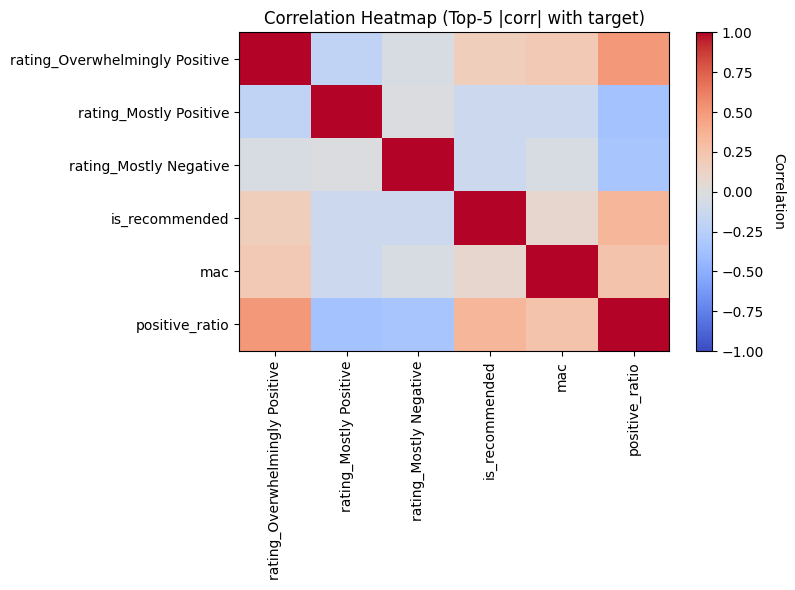


=== Top VIFs (higher means more collinearity) ===


,feature,VIF
7,review_year,375496.17
6,release_year,373524.15
11,steam_deck,4984.14
8,win,1258.21
0,hours,11.76
20,rating_Very Positive,10.04
21,hours_sq,9.36
12,is_recommended,8.09
17,rating_Overwhelmingly Positive,5.15
22,priceorig_x_discount,3.80



=== Test metrics ===


,Model,RMSE,R2
0,Linear,3.8817,0.8812
1,Ridge,3.8817,0.8812



Best Ridge alpha: 1.000

=== Top 15 Ridge coefficients (by magnitude) ===


,feature,coef
17,rating_Overwhelmingly Positive,15.230198
20,rating_Very Positive,13.947129
14,rating_Mostly Positive,4.847203
13,rating_Mostly Negative,-1.904396
18,rating_Positive,1.699598
16,rating_Overwhelmingly Negative,-0.889605
12,is_recommended,0.549280
0,hours,-0.534336
15,rating_Negative,-0.489899
19,rating_Very Negative,-0.380162


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score

# display prefs
pd.set_option("display.float_format", "{:.6f}".format)
pd.options.display.max_columns = None
pd.options.display.width = 1800
np.set_printoptions(suppress=True)

# -------------------------
# Prep
# -------------------------
TARGET = "positive_ratio"
df = steam.copy()

# years from dates
df["release_year"] = pd.to_datetime(df["date_release"], errors="coerce").dt.year
df["review_year"] = pd.to_datetime(df["date"], errors="coerce").dt.year
for col in ["release_year", "review_year"]:
    df[col] = df[col].fillna(df[col].median())

# booleans to 0/1
for c in ["win", "mac", "linux", "steam_deck", "is_recommended"]:
    df[c] = df[c].astype(int)

# choose features
num_cols = ["hours", "price_original", "price_final", "discount",
            "user_reviews", "reviews", "release_year", "review_year"]
cat_cols = ["rating"]
bin_cols = ["win", "mac", "linux", "steam_deck", "is_recommended"]

use_cols = num_cols + bin_cols + cat_cols + [TARGET]
df = df[use_cols].dropna()

# one-hot encode rating
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# polynomial + one interaction
df["hours_sq"] = df["hours"] ** 2
df["priceorig_x_discount"] = df["price_original"] * df["discount"]

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(float)

# -------------------------
# Split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# -------------------------
# Correlations (ONLY top-5 strongest |corr| with target)
# -------------------------
# sample for speed on huge data
Xs = X_train.sample(n=min(100000, len(X_train)), random_state=42)
ys = y_train.loc[Xs.index]

corr_full = pd.concat([Xs, ys.rename(TARGET)], axis=1).corr()

# pick top-5 by absolute correlation with target (keep the sign)
corr_w_target = corr_full[TARGET].drop(TARGET)
top5_index = corr_w_target.abs().sort_values(ascending=False).head(5).index
top5_series = corr_w_target.loc[top5_index].sort_values(key=lambda s: s.abs(), ascending=False)

# pretty table of the top-5
top5_df = top5_series.round(3).to_frame("correlation").reset_index().rename(columns={"index": "feature"})
print("\n=== Top 5 correlations with target (by absolute value) ===")
display(top5_df.style.format({"correlation": "{:.3f}"})
        .background_gradient(subset=["correlation"], cmap="RdBu_r", vmin=-1, vmax=1))

# small correlation table among those 5 features + target
cols_for_heatmap = list(top5_index) + [TARGET]
corr_small = corr_full.loc[cols_for_heatmap, cols_for_heatmap].round(2)

print("\n=== Correlation table (top-5 features + target) ===")
display(corr_small.style.format("{:.2f}").background_gradient(cmap="RdBu_r", vmin=-1, vmax=1))

# heatmap scaled -1..1 with a diverging colormap
plt.figure(figsize=(8, 6))
im = plt.imshow(corr_small, vmin=-1, vmax=1, cmap="coolwarm", aspect="auto", interpolation="nearest")
plt.title("Correlation Heatmap (Top-5 |corr| with target)")
plt.xticks(ticks=np.arange(len(cols_for_heatmap)), labels=cols_for_heatmap, rotation=90)
plt.yticks(ticks=np.arange(len(cols_for_heatmap)), labels=cols_for_heatmap)
cbar = plt.colorbar(im)
cbar.set_label("Correlation", rotation=270, labelpad=15)
plt.tight_layout()
plt.show()

# -------------------------
# VIF (optional)
# -------------------------
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    def vif_table(X_in, sample_rows=10000):
        Xv = X_in.sample(n=min(sample_rows, len(X_in)), random_state=42).astype(float)
        arr = Xv.values
        names = Xv.columns
        vals = [variance_inflation_factor(arr, i) for i in range(arr.shape[1])]
        out = pd.DataFrame({"feature": names, "VIF": vals})
        return out.sort_values("VIF", ascending=False)

    vif = vif_table(X_train)
    print("\n=== Top VIFs (higher means more collinearity) ===")
    display(vif.head(10).style.format({"VIF": "{:.2f}"}))
except ModuleNotFoundError:
    print("\nVIF skipped (statsmodels not installed). Use the heatmap and table above.")

# -------------------------
# Scale + Models
# -------------------------
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_s, y_train)
pred_lr = lr.predict(X_test_s)

ridge = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0], cv=3)
ridge.fit(X_train_s, y_train)
pred_ridge = ridge.predict(X_test_s)

# manual RMSE for compatibility
rmse_lr = np.sqrt(mean_squared_error(y_test, pred_lr))
r2_lr = r2_score(y_test, pred_lr)
rmse_ridge = np.sqrt(mean_squared_error(y_test, pred_ridge))
r2_ridge = r2_score(y_test, pred_ridge)

print("\n=== Test metrics ===")
metrics_df = pd.DataFrame({"Model": ["Linear", "Ridge"], "RMSE": [rmse_lr, rmse_ridge], "R2": [r2_lr, r2_ridge]})
display(metrics_df.style.format({"RMSE": "{:.4f}", "R2": "{:.4f}"}))

print(f"\nBest Ridge alpha: {ridge.alpha_:.3f}")

# -------------------------
# Top coefficients (Ridge)
# -------------------------
coef = pd.DataFrame({"feature": X_train.columns, "coef": ridge.coef_})
coef["abs"] = coef["coef"].abs()
top_coef = coef.sort_values("abs", ascending=False).drop(columns=["abs"]).head(15)

print("\n=== Top 15 Ridge coefficients (by magnitude) ===")
display(top_coef.style.format({"coef": "{:.6f}"}))
